# What is PyOD?

* The Python Outlier Detection (PyOD) module makes your anomaly detection modeling easy. It collects a wide range of techniques ranging from SUPERVISED learning to UNSUPERVISED learning techniques. You don’t need to test every technique in order to find anomalies. Depending on your data, you will find some techniques work better than others. 
* See the link https://towardsdatascience.com/anomaly-detection-with-pyod-b523fc47db9 for the types of PyOD algorithm in the PyOD packages such as PCA, one-class SVM, autoencoders, etc. 
* As mentioned above, PyOD provide not just unsupervised algorithms, but also supervised. 
* BE CAREFUL: algorithms based on outlier detection has the fundamental assumption: the positive class samples are the outliers in a certain distribution. If for some cases, the assumption is not true, then this type of algorithms will not work.

# The Three Key Steps in Anomaly Detection

* Build your model
* Determine a reasonable boundary
* Present the summary statistics of the normal and abnormal clusters

### Step 1: Build your Model

* Generate some data with outliers (10 percent) using generate_data() of PyOD.  

In [8]:
import numpy as np
import pandas as pd
from pyod.utils.data import generate_data
import matplotlib.pyplot as plt

contamination = 0.1 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 2      # number of features
X_train, y_train, X_test, y_test = generate_data(
    n_train=n_train, n_test=n_test, n_features= n_features, contamination=contamination)
 

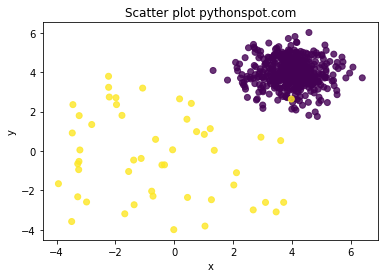

In [29]:
# plt.scatter(X_train[0], X_train[1], c=y_train, alpha=0.8) 
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, alpha=0.8)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

* The yellow points in the scatterplot are the ten percent outliers. Obviously the “normal” observations are the purple points.
* Below use KNN to of pyod. 
    * The training of KNN should determine a proper value of K. Note the KNN is a non-parametric model and the computation time is thus scaled with the number of samples. 
    * Once the K is determined, then we can calculate the _decision_scores_ for each sample, basically the average distance from the sample considered to other samples within a sphere used in KNN (figure the details later if necessary)

In [32]:
# train kNN detector
from pyod.models.knn import KNN
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)
# If you want to see the predictions of the training data, you can use this way:
y_train_scores = clf.decision_scores_
# decision_scores_ : numpy array of shape (n_samples,): The outlier scores of the training data. The higher, the more abnormal. Outliers tend to have higher
# scores. This value is available once the detector is fitted. 

<img src="knn.png" style="width:600px;height:400px"/>

* With the trained k-NN model, you can apply to the test dataset to predict outliers. The function “decision_functions()” generates the anomaly score based on your model predictions. 

* How is the “anomaly score” defined? Recall the k-NN model uses the Euclidean distance to measure the distance. An outlier is a point that is distant from neighboring points, so the outlier score is defined by the distance value. Each point will have an outlier score. Our job is to find those points with high outlier scores. We can use a histogram to find those points.

In [34]:
# Now we have the trained K-NN model, let's apply to the test data to get the predictions
y_test_pred = clf.predict(X_test) # outlier labels (0 or 1)
# Because it is '0' and '1', we can run a count statistic. There are 44 '1's and 456 '0's. The number of anomalies is roughly ten percent, as we have generated before:
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))
#{0: 456, 1: 44}
# And you can generate the anomaly score using clf.decision_function:
y_test_scores = clf.decision_function(X_test)

### Step 2: Determine a reasonable boundary

A high anomaly score means more abnormal. The histogram below shows there are outliers. If we choose 1.0 to be the cut point, we can suggest those >=1.0 to be outliers

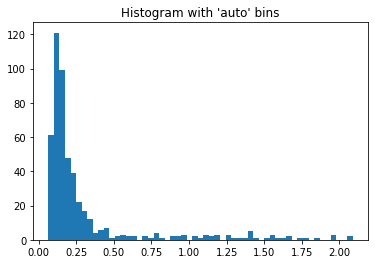

In [35]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

### Step 3: Present the summary statistics of the normal and abnormal clusters

* This step is an important step. It gives your clients the business insights that they can act upon. In our case we have two features (labeled “Feature 0” and “Feature “1”). The average anomaly score in Cluster 1 is much higher than that of Cluster 0. The summary statistics also show dramatic differences between the two clusters. We thus believe the data points in Cluster 1 could be anomalous and deserve further inspection.

In [38]:
import pandas as pd
# Let's see how many '0's and '1's. We get 452 '0's and 48 '1's.
df_test = pd.DataFrame(X_test)
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<1, 0, 1)
df_test['cluster'].value_counts()

0    461
1     39
Name: cluster, dtype: int64

In [40]:
df_test.head()

,0,1,score,cluster
0,4.289766,5.030631,0.138444,0
1,5.041326,3.834981,0.144625,0
2,3.856254,4.698462,0.102842,0
3,4.260850,3.872624,0.096722,0
4,3.546667,4.882629,0.132981,0


In [41]:
# Now let's show the summary statistics:
# df_test.groupby('y_by_average_cluster').mean()
df_test.groupby('cluster').mean()

,0,1,score
cluster,,,
0,3.895891,3.962696,0.203498
1,0.031063,-1.036351,1.458374


# Outlier Detection Models Are Prone to Outliers

* However, I want to warn you outlier detection models tend to be very sensitive to outliers. In our case the unsupervised k-NN model can easily commit overfitting. We need to produce stable models. 

* Comments: 
    * When fitting KNN with train data set, we should have used supervised learning to determine the K. That is the reason we can have overfitting mentioned above. 
    * When Calculating outliers from the error score distribution, we did not use class labels and thus we perform unsupervised learning. 
    * If consider the general whole process, it is like a semi-supervised learning as we use both types of learning.
    * In this post, both normal and outliers are used to train the model (here is KNN). Sometimes like in the autoencoder case in another article, people also use only the normal data to train the model. 

# Achieve Model Stability by Aggregating Multiple Models

* The solution is to train multiple models then aggregate the scores. By aggregating multiple models, the chance of overfitting is greatly reduced and the prediction accuracy will be improved. The PyOD module offers four methods to aggregate the outcome. You only need to use one method to produce your aggregate outcome.
    * Average
    * Maximum of Maximum (MOM)
    * Average of Maximum (AOM)
    * Maximum of Average (MOA)

We will first generate 20 k-NN models and collect all the model predictions in one dataset. Each of the 500 observations will have 20 predictions.

In [ ]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer

**There are some version issues for the code above. So the following code cannot be run.** 

In [ ]:
# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Test a range of k-neighbors from 10 to 200. There will be 20 k-NN models.

n_clf = 20
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 
 120, 130, 140, 150, 160, 170, 180, 190, 200]

# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape
# Modeling
for i in range(n_clf):
    k = k_list[i]
    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

### Method 1: Average

In [ ]:
# Combination by average
# The test_scores_norm is 500 x 20. The "average" function will take the average of the 20 columns. The result "y_by_average" is a single column: 
y_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

* In our case it identifies 69 data points that have the outlier scores higher than 0. In order to get the summary statistics for each cluster, we do the following code, which produces the average values as below.

In [ ]:
df_test.groupby(‘y_by_average_cluster’).mean()

### Method 2: The Maximum of Maximum (MOM)

In [ ]:
# Combination by mom
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [ ]:
df_test = pd.DataFrame(X_test)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<0, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

* When we use the Maximum-of-Maximum method, we get 73 data points that have the outlier scores higher than 0. We use the following code to produce the summary statistics by cluster.

In [ ]:
df_test.groupby('y_by_maximization_cluster').mean()

### Method 3: The Average of Maximum (AOM)

In [ ]:
# Combination by aom
y_by_aom = aom(test_scores_norm, n_buckets=5)
             
import matplotlib.pyplot as plt
plt.hist(y_by_aom, bins='auto')  # arguments are passed to np.histogram
plt.title("Average of Maximum")
plt.show()

In [ ]:
df_test = pd.DataFrame(X_test)
df_test['y_by_aom_score'] = y_by_aom
df_test['y_by_aom_cluster'] = np.where(df_test['y_by_aom_score']<0, 0, 1)
df_test['y_by_aom_cluster'].value_counts()

* When we use the Average-of-Maximum method, we get 72 data points that have the outlier scores higher than 0. We use the following code to produce the summary statistics by cluster.

In [ ]:
df_test.groupby('y_by_aom_cluster').mean()

### Method 4: The maximum of average (MOA)

In [ ]:
# Combination by moa
y_by_moa = moa(test_scores_norm, n_buckets=5)

import matplotlib.pyplot as plt
plt.hist(y_by_moa, bins='auto')  # arguments are passed to np.histogram
plt.title("Maximum of Average")
plt.show()

In [ ]:
df_test = pd.DataFrame(X_test)
df_test['y_by_moa_score'] = y_by_moa
df_test['y_by_moa_cluster'] = np.where(df_test['y_by_moa_score']<0, 0, 1)
df_test['y_by_moa_cluster'].value_counts()

* When we use the Maximum-of-Average method, we get 69 data points that have the outlier scores higher than 0. We use the following code to produce the summary statistics by cluster.

In [ ]:
df_test.groupby('y_by_moa_cluster').mean()